# Project 6 - Clustering

import all needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# set options
pd.options.display.max_rows = 99999

## Dataset: people

The people Dataset contains interviwed male and female persons aged between 15-30 years. Each person answered a questionary of about 150 topics, from music to movies, taste for mathematics, and etc. There are also questions regarding alcohol and tobacco consumption, internet usage and etc.

The dataset has many features (like movies and music genres) ranging from 0-5, 0 usually meaning 'strongly disagree' and 5 usually meaning 'strongly agree' (higher is better) 

Lots of interesting questions may rise such as:

- May clustering help us identify patterns among young people? Does the pattern of music someone likes influences the movie taste?

- There are 150 dimensions in people's taste. Could we understand people's taste with a smaller number of dimensions? Meaning some of the questions were almost redundant?

- How to visualize it properly? 

- Were there people who intentionally randomly responded the survey? Is there a way to find them?


And we will try to answer them!


In [2]:
people = pd.read_csv('responses.csv')
descriptions = people.describe().T

In [4]:
descriptions.loc['Age']

count    1003.000000
mean       20.433699
std         2.828840
min        15.000000
25%        19.000000
50%        20.000000
75%        22.000000
max        30.000000
Name: Age, dtype: float64

- It seems that the range from the dataset are from 15 years to 30 year. Adding an "age Group" woud be interesting, maybe? We will add a new colum with 4 age categories...


In [9]:
#grouping age by categories:
my_dict = {'A':[15,16,17,18], 'B':[19,20,21,22], 'C':[23,24,25,26], 'D':[27,28,29,30]}
age_groups = {}

for key in my_dict.keys():
    for value in my_dict[key]:
        age_groups[value] = key

people.loc[:,'Age'] = people.loc[:,'Age'].fillna(round(people.loc[:,'Age'].mean()))
people['age_group'] = people.loc[:,'Age'].apply(lambda x: age_groups[x])

# indexing people by their Gender-Age
people.index = people.apply(lambda x: str(x.Gender) +'-'+ str(int(x.Age)), axis=1)

Now, let us check further the data.

Let's Check if "Object Type" columns are really categories and not numbers in string format:

In [7]:
people.select_dtypes(include=['object']).head()

,Smoking,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,never smoked,drink a lot,i am always on time,never,few hours a day,female,right handed,college/bachelor degree,no,village,block of flats
1,never smoked,drink a lot,i am often early,sometimes,few hours a day,female,right handed,college/bachelor degree,no,city,block of flats
2,tried smoking,drink a lot,i am often running late,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats
3,former smoker,drink a lot,i am often early,only to avoid hurting someone,most of the day,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,tried smoking,social drinker,i am always on time,everytime it suits me,few hours a day,female,right handed,secondary school,no,village,house/bungalow


All 12 columns seem to be fair categories. It won't give us any problems if we use pd.get_dummies()

### QUESTION: May clustering help us identify patterns among young people?

We will create functions that do things:
- Apply PCA tecnique to help us see all columns as two variables. This will improve analysis and see how people are distanced...

In [ ]:
def pca_fit(X,n_components):
    # instantiate and fit the pca object
    X_std = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components)
    pca.fit(X_std)

    print(f'each pca explains: {pca.explained_variance_ratio_}')
    explains = pca.explained_variance_ratio_.sum()
    print(f'Both components explain together {round(explains*100,2)}% of the data')

    #now transform!
    X_pca = pca.transform(X_std)

    #check results
    print("\noriginal shape:   ", X.shape)
    print("\ntransformed shape:", X_pca.shape)
    pc1 = X_pca[:,0]
    pc2 = X_pca[:,1]
    
    return pc1, pc2, explains

- We will also create a function for ploting Kmeans using different number of clusters

In [ ]:
#creating a quicky, unpretentious Kmeans with N clusters, to check if we have the four age groups ('A','B','C','D')
def kmeans_clustering(people, clusters):
    
    people = people.dropna()

    X = pd.get_dummies(people)
    X_std = StandardScaler().fit_transform(X)

    kmeans = KMeans(clusters)

    kmeans.fit(X_std)

    labels = kmeans.labels_

    #add to the dataframe as groups
    people['label'] = labels + 1


    # generate distribution per group
    df = people.loc[:,['age_group','Gender','label']]
    df.index = df.apply(lambda x: str(x.Gender)[0:3].upper() +'-'+ str(x.age_group), axis=1)
    df = pd.pivot_table(data=df.loc[:,['age_group','label']],index=df.index,columns='label',aggfunc='count',fill_value=0)
    df = df.apply(lambda x: round(x / x.sum(),2), axis=1)

    #generate data for plot
    pc1 = X_pca[:,0]
    pc2 = X_pca[:,1]

    c_labels = kmeans.labels_

    return df, pc1, pc2, c_labels

- Now let us see the results

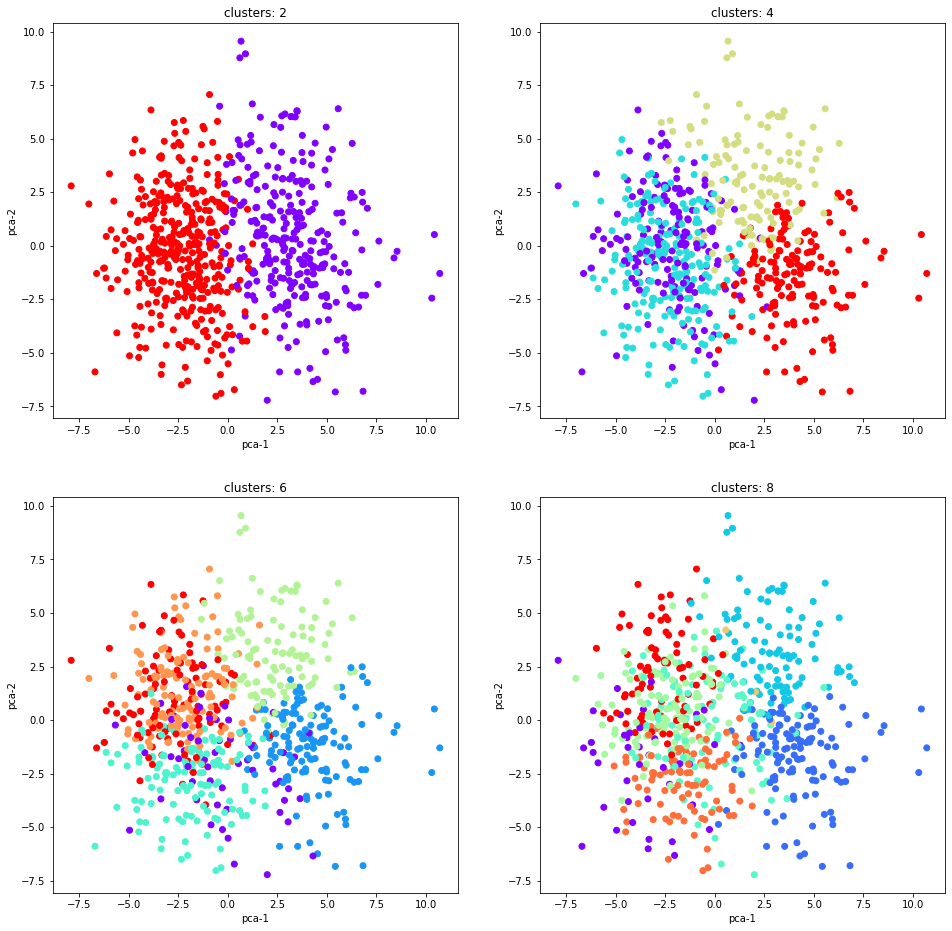

In [264]:
fig, axis = plt.subplots(nrows=2,ncols=2,figsize=(16,16))

axis = [axe for pair in axis for axe in pair]

dfs = {}

for axe, clusters in zip(axis,[2,4,6,8]):
    df, pc1, pc2, c_labels = kmeans_clustering(people, clusters)
    axe.scatter(x=pc1, y=pc2, c=c_labels, cmap='rainbow')
    axe.set_title(f'clusters: {clusters}')
    axe.set_xlabel('pca-1')
    axe.set_ylabel('pca-2')
    dfs[clusters] = df

Let us visualize the results as tables.
* Each table represents using 2, 4 and 6 clusters. Each Label was organized to help us identify gender-age groups. For example, FEM-B corresponds to a Female interviewd person with age within 19-22. 
* Each row represents the distribution of the amount categorized people by groups. For example, for the first Table, roughly 4% of females are grouped in the cluster-1, and the "rest" 96% fell within the cluster-2

A: 15-18
B: 19-22
C: 23-26
D: 27-30

In [265]:
#EXPLICAR O QUE SÂO OS DADOS NA TABELA ABAIXO

for cluster in [2,4,6]:
    display(dfs[cluster])

age_group      
label         1     2
FEM-A      0.04  0.96
FEM-B      0.05  0.95
FEM-C      0.05  0.95
FEM-D      0.00  1.00
MAL-A      0.98  0.02
MAL-B      0.97  0.03
MAL-C      0.98  0.02
MAL-D      1.00  0.00

age_group                  
label         1     2     3     4
FEM-A      0.40  0.54  0.02  0.04
FEM-B      0.42  0.52  0.04  0.01
FEM-C      0.32  0.57  0.08  0.02
FEM-D      0.27  0.47  0.27  0.00
MAL-A      0.07  0.02  0.30  0.61
MAL-B      0.02  0.01  0.36  0.61
MAL-C      0.02  0.05  0.58  0.35
MAL-D      0.00  0.00  0.73  0.27

age_group                              
label         1     2     3     4     5     6
FEM-A      0.14  0.00  0.39  0.01  0.30  0.16
FEM-B      0.10  0.00  0.25  0.03  0.33  0.28
FEM-C      0.10  0.00  0.35  0.02  0.25  0.28
FEM-D      0.07  0.00  0.20  0.07  0.47  0.20
MAL-A      0.11  0.54  0.02  0.24  0.09  0.00
MAL-B      0.04  0.58  0.02  0.32  0.01  0.03
MAL-C      0.05  0.33  0.00  0.53  0.05  0.05
MAL-D      0.00  0.20  0.07  0.73  0.00  0.00

So... there is clearly a distinction between Males and Females, when analyzing 2 clusters.

With 4 clusters, Females tend to be grouped in clusters 1 and 2, while males are concentrated on groups 3 and 4.

Groups % change according to age. For example, young MAL-A proportion for clusters 3:4 is 30:61, while MAL-D is 73:27.

Therefore, sex and age are important factors at first, in this crude analysis.

### Does the pattern of music someone likes influences the movie taste?

Taking in consideration only musical taste and movie taste for clustering... (without gender/age)

-> What would happen to the result if we added age/gender in the Kmeans?

In [97]:
mmpeople = people.loc[:,['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country', 
                         'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
                         'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
                         'Alternative', 'Latino', 'Techno, Trance', 'Opera', 'Movies', 'Horror',
                         'Thriller', 'Comedy', 'Romantic', 'Sci-fi', 'War', 'Fantasy/Fairy tales',
                         'Animated', 'Documentary', 'Western', 'Action']]

pc1, pc2, explains = pca_fit(mmpeople,n_components=2)

NameError: name 'pca_fit' is not defined

Again, we create a function that uses Kmeans

In [ ]:
def kmeans_mmclustering(mmpeople, clusters):
    
    """This function receives a dataframe and the number of cluters. It returns the dataframe with a column
    regarding the respective cluster that the row is represented. It also returns the labels."""
    
    mmpeople = mmpeople.dropna()

    X = mmpeople
    X_std = StandardScaler().fit_transform(X)

    kmeans = KMeans(clusters)

    kmeans.fit(X_std)

    labels = kmeans.labels_

    #add to the dataframe as groups
    mmpeople['label'] = labels + 1

    #generate data for plot
    c_labels = kmeans.labels_
    
    return mmpeople, c_labels

We then plot 4 plots, for a distinct number of clusters

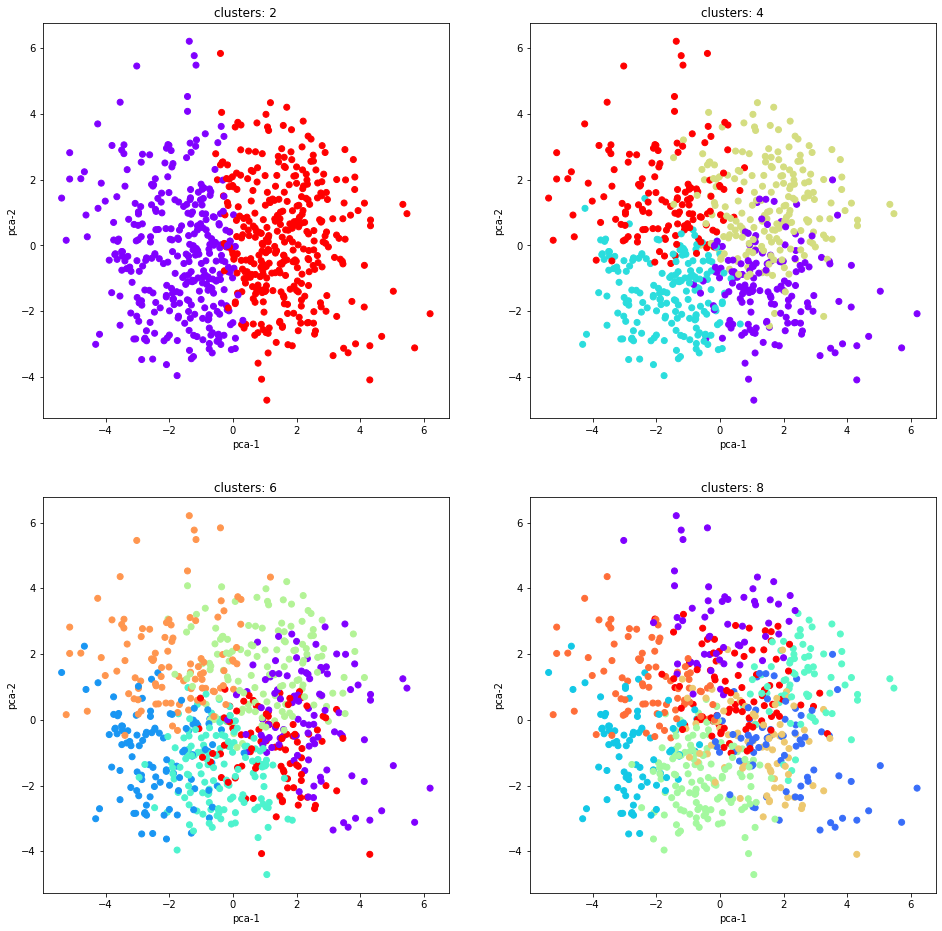

In [310]:
fig, axis = plt.subplots(nrows=2,ncols=2,figsize=(16,16))

axis = [axe for pair in axis for axe in pair]

dfs = {}

for axe, clusters in zip(axis,[2,4,6,8]):
    df, c_labels = kmeans_mmclustering(mmpeople, clusters)
    axe.scatter(x=pc1, y=pc2, c=c_labels, cmap='rainbow')
    axe.set_title(f'clusters: {clusters}')
    axe.set_xlabel('pca-1')
    axe.set_ylabel('pca-2')
    dfs[clusters] = df

Checking the Elbow method for KMeans will help us take a look at the optimal number of clusters!

c:\users\vfarn\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


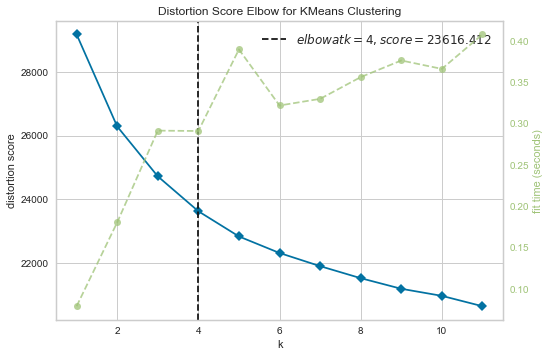

In [379]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(mmpeople)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

So far so good! We will keep 4 clusters!

We now add age and gender for analysis of the results! We will store in the variable points, representing the mean of score (0-5) that each categorie was given according to the group.

In [8]:
results = dfs[4].copy()
results = pd.get_dummies(pd.concat([results, people.loc[:,['Gender','Age']]],axis=1))
points = results.groupby(by='label').mean()
points

NameError: name 'dfs' is not defined

In [345]:
points

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Age,Gender_female,Gender_male
label,,,,,,,,,,,,,,,,,,,,,
1,4.818182,3.298701,3.720779,2.850649,2.681818,3.837662,3.558442,3.928571,3.987013,2.357143,...,3.746753,3.655844,4.383117,4.337662,4.162338,2.616883,4.097403,20.792208,0.558442,0.441558
2,4.766667,3.277778,3.588889,2.100000,1.866667,2.327778,2.838889,4.061111,3.177778,1.472222,...,2.444444,2.283333,4.111111,4.011111,3.100000,1.522222,3.094444,20.194444,0.888889,0.111111
3,4.850000,3.115000,2.235000,2.505000,2.190000,3.440000,2.760000,2.720000,4.560000,3.265000,...,3.110000,3.305000,3.745000,3.875000,3.870000,2.160000,3.210000,20.350000,0.585000,0.415000
4,4.574468,3.574468,2.936170,1.482270,1.716312,2.226950,1.787234,3.198582,3.248227,2.177305,...,3.326241,3.666667,2.751773,2.872340,3.411348,2.177305,4.049645,20.078014,0.283688,0.716312


So... Does music likeness affect Movie likeness? What are the 5 top genre scorers and the top least genres for each group?

In [447]:
# we store the music genres
music_points = points.loc[:,['Slow songs or fast songs', 'Dance', 'Folk', 'Country', 
                         'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
                         'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
                         'Alternative', 'Latino', 'Techno, Trance', 'Opera']]
#and movie genres
movies_points = points.loc[:,['Horror', 'Thriller', 'Comedy', 'Romantic', 'Sci-fi', 
                              'War', 'Fantasy/Fairy tales', 'Animated', 'Documentary', 'Western', 'Action']]

# and now we create a pandas datrafame for each cluster (1,2,3,4)
tastes = pd.DataFrame()

for cluster in [1,2,3,4]:
    lowmusic = list(music_points.loc[cluster].sort_values()[0:5].index)
    topmusic = list(music_points.loc[cluster].sort_values(ascending=False)[0:5].index)
    lowmovies = list(movies_points.loc[cluster].sort_values()[0:5].index)
    topmovies = list(movies_points.loc[cluster].sort_values(ascending=False)[0:5].index)
    
    minidf = pd.DataFrame({'cluster': cluster,
                           'good_music': topmusic,'bad_music': lowmusic,
                           'good_movies': topmovies,'bad_movies': lowmovies})
    
    
    tastes = pd.concat([tastes,minidf])

tastes = tastes.set_index(keys='cluster')

now we check which groups like what others dont!!
We will collor red each genre that IS LIKED by a cluster-group and IS ALSO UNLIKED by another CLUSTER-GROUP

In [566]:
# getting the unique genres from "good" that appear in "bad" genres.
gmusic = list(tastes.loc[tastes.good_music.apply(lambda x: x in list(tastes.bad_music))].good_music.unique())
gmovies = list(tastes.loc[tastes.good_movies.apply(lambda x: x in list(tastes.bad_movies))].good_movies.unique())

# and now we color the dataframe to take a look
tastes.reset_index().style.applymap(lambda x: f"color: {'red' if ((x in gmusic)|(x in gmovies)) else 'black'}")

,cluster,good_music,bad_music,good_movies,bad_movies
0,1,Rock,Metal or Hardrock,Comedy,Western
1,1,Pop,Punk,Fantasy/Fairy tales,Horror
2,1,Classical music,Country,Animated,Thriller
3,1,Dance,Folk,Documentary,War
4,1,Latino,Opera,Action,Sci-fi
5,2,Pop,Metal or Hardrock,Comedy,Western
6,2,Dance,Opera,Romantic,War
7,2,Latino,Punk,Fantasy/Fairy tales,Horror
8,2,"Hiphop, Rap",Country,Animated,Sci-fi
9,2,Slow songs or fast songs,Folk,Documentary,Thriller


Choosing 6 genres of music and movie:
Music:
- "Metal or Hardrock" are the most "unliked" for clusters 1 and 2, and are liked by cluster 3.
- "Dance" is liked by 1,2 and 4, and more unliked by 3.
- "Latino" is more liked by 1 and 2 and more unliked by 3 and 4.

Movies:
- "Fantasy/Fairy tales" is "more liked" by 1,2 and 3 and "more unliked" by 4.
- "War" is "more liked" by 4 and "more unliked" by 1 and 2.
- "Thriller" is "more liked" by 3 and 4 and "more unliked" by 1 and 2.

In [517]:
tofilter = ['Metal or Hardrock', 'Dance', 'Latino', "Fantasy/Fairy tales", "War", "Thriller"]

We can now use yellowbrick to visualizer in a 2D space how liking a genre separates you from another genre.

In [ ]:
from yellowbrick.features.pca import PCADecomposition

fig, ax = plt.subplots(figsize=(14,9))

visualizer = PCADecomposition(scale=True, proj_features=True)
components = visualizer.fit_transform(numerical_kmeans,fifa['Labels'])
    
visualizer.show()

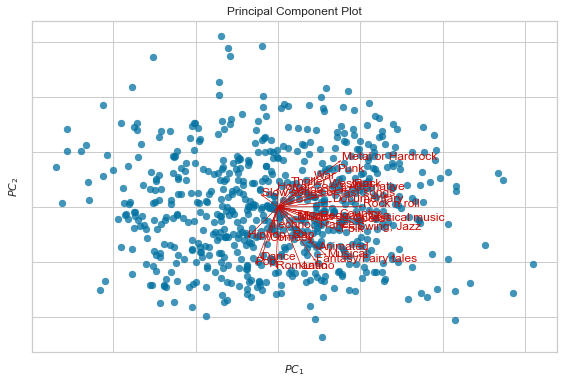

In [536]:
from yellowbrick.features import PCA as PCA_yellow

visualizer = PCA_yellow(scale=True, proj_features=True)
components = visualizer.fit_transform(mmpeople)

# for i, name in enumerate(tofilter):
#     visualizer.ax.annotate(name, (components[i, 0]+0.1, components[i, 1]-.1))


visualizer.show()

What can we learn from this? That, if you are a netflix like service, if your customer likes 'Romantic' Movies, you probably wont recommend war movies!

### There are 150 dimensions in people's taste. Could we understand people's taste with a smaller number of dimensions? Meaning some of the questions were almost redundant?

-> We wont use get dummies for this one because we dont want to change the initial number of columns!

In [ ]:
"""
Unique values for each Object typed column:

Smoking-4
Alcohol-3
Punctuality-3
Lying-4
Internet usage-4
Gender-2
Left - right handed-2
Education-6
Only child-2
Village - town-2
House - block of flats-2
"""

We will transform gategories in numbers first, not only for columns with more than 2 unique values, but also the others with two categories...

Columns to be transformed are: 'Smoking', 'Alcohol', 'Punctuality', 'Lying', 'Internet usage', 'Education', 'Gender', 'Left - right handed', 'Only child', 'Village - town', 'House - block of flats'

In [87]:
from sklearn.preprocessing import LabelEncoder

# drop NaNs
test = people.dropna()

# select columns
cols = list(people.select_dtypes(include=['object']).columns)

#now LabelEncoder()
for column in cols:
    to_fit = test.loc[:,column]
    labelEncoder = LabelEncoder()
    labelEncoder.fit(to_fit)
    test.loc[:,column] = labelEncoder.transform(to_fit)

c:\users\vfarn\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [90]:
#we first normalize the data
X_std = StandardScaler().fit_transform(test)

max_components = X_std.shape[1]

y = []

for comp in np.arange(2,max_components):
    # instantiate and fit the pca object
    pca = PCA(comp)
    pca.fit(X_std)
    
    # store the sum of the level of explained_variance_ratio
    y.append(pca.explained_variance_ratio_.sum())

In [93]:
#create dataframe
check = pd.DataFrame({'Number of components':np.arange(2,max_components), 'Explains ratio sum':y})

#filter with mask
minimum_number = check.loc[check.loc[:,'Explains ratio sum'] > 0.80].loc[:,'Number of components'].min()
print(f'The minimun number of dimensions for keeping 80% of the information is {minimum_number}')

minimum_number = check.loc[check.loc[:,'Explains ratio sum'] > 0.90].loc[:,'Number of components'].min()
print(f'The minimun number of dimensions for keeping 90% of the information is {minimum_number}')

minimum_number = check.loc[check.loc[:,'Explains ratio sum'] > 0.99].loc[:,'Number of components'].min()
print(f'The minimun number of dimensions for keeping 99% of the information is {minimum_number}')

The minimun number of dimensions for keeping 80% of the information is 73
The minimun number of dimensions for keeping 90% of the information is 100
The minimun number of dimensions for keeping 99% of the information is 141


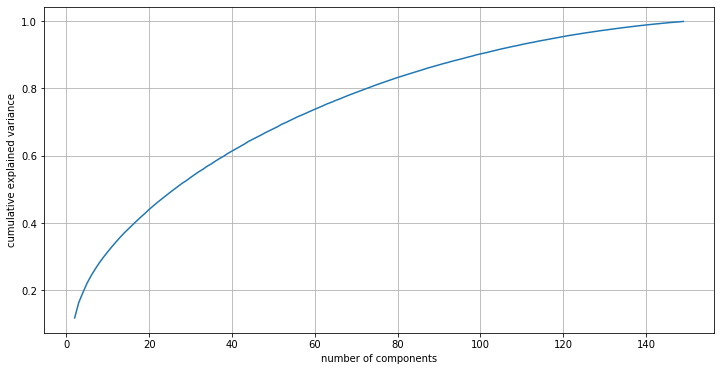

In [92]:
fig, axe = plt.subplots(figsize=(12,6))

axe.plot(np.arange(2,max_components), y)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
axe.grid()
plt.show()

One thing we can see is that with a little less then half of the number of columns (73), we will still have a circa 80% of the information!

141 columns grant us about 99% of the information!

Therefore, we can afford lowering some columns and still have most of info

### How to visualize it properly? Example with Movies and Music dataframe

We shall use Hiearchycal Clustering here to check this!

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [98]:
mmpeople = people.loc[:,['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country', 
                         'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
                         'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
                         'Alternative', 'Latino', 'Techno, Trance', 'Opera', 'Movies', 'Horror',
                         'Thriller', 'Comedy', 'Romantic', 'Sci-fi', 'War', 'Fantasy/Fairy tales',
                         'Animated', 'Documentary', 'Western', 'Action']]

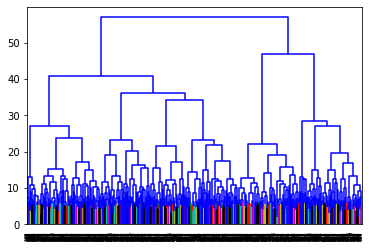

In [101]:
from scipy.cluster import hierarchy

X = mmpeople.dropna()

dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(StandardScaler().fit_transform(X), method = 'ward'), color_threshold=6)

### Were there people who intentionally randomly responded the survey? Is there a way to find them?

In [102]:
bob = people.dropna()

In [104]:
bob.describe().T

,count,mean,std,min,25%,50%,75%,max
Music,674.0,4.762611,0.594699,1.0,5.00,5.0,5.00,5.0
Slow songs or fast songs,674.0,3.295252,0.795833,1.0,3.00,3.0,4.00,5.0
Dance,674.0,3.078635,1.179841,1.0,2.00,3.0,4.00,5.0
Folk,674.0,2.264095,1.120517,1.0,1.00,2.0,3.00,5.0
Country,674.0,2.117211,1.063888,1.0,1.00,2.0,3.00,5.0
Classical music,674.0,2.982196,1.244176,1.0,2.00,3.0,4.00,5.0
Musical,674.0,2.759644,1.281403,1.0,2.00,3.0,4.00,5.0
Pop,674.0,3.451039,1.165938,1.0,3.00,4.0,4.00,5.0
Rock,674.0,3.787834,1.152979,1.0,3.00,4.0,5.00,5.0
Metal or Hardrock,674.0,2.354599,1.396371,1.0,1.00,2.0,3.00,5.0
